In [ ]:
import tensorflow as tf
import numpy as np
np.random.seed(777)
tf.random.set_seed(777)

class Individual:
    def __init__(self, num_of_features, num_of_classes, model=None, vector=None):
        self.fitness = None
        self.set_model(model, num_of_features, num_of_classes)
        if vector is not None:
            self.vector = vector
            self.decode()
        else:
            self.encode()


    def set_model(self, model, num_of_features=0, num_of_classes=0):
        if model is None:
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(512, activation='relu', input_shape=(num_of_features,))
            ])

            if num_of_classes == 2:
                model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
            else:
                model.add(tf.keras.layers.Dense(num_of_classes, activation='softmax'))

            self.model = model
        else:
            self.model = tf.keras.models.clone_model(model)

    def encode(self):
        self.vector = np.concatenate([w.ravel() for w in self.model.get_weights()])

    def decode(self):
        weights = []
        idx = 0
        for layer in self.model.layers:
            shape = layer.get_weights()[0].shape
            size = np.prod(shape)
            weights.append(self.vector[idx:idx + size].reshape(shape))
            idx += size
        biases = [self.vector[idx:idx + len(layer.get_weights()[1])] for layer in self.model.layers]
        idx += sum(len(b) for b in biases)
        self.model.set_weights([w for pair in zip(weights, biases) for w in pair])

    def evaluate(self, x, y, batch_size=32):
        if self.fitness is not None:
            return self.fitness
        self.decode()
        predictions = self.model.predict(x, batch_size=batch_size)

        is_softmax = self.model.layers[-1].activation == tf.keras.activations.softmax
        is_sigmoid = self.model.layers[-1].activation == tf.keras.activations.sigmoid

        if is_softmax:
            predictions = np.argmax(predictions, axis=1)
        elif is_sigmoid:
            predictions = np.round(predictions).astype(int)

        num_correct = np.sum(predictions == y)
        p = len(y)
        fitness = (100 / p) * num_correct
        self.fitness=fitness
        return fitness

# Example usage:
# num_of_features = 10
# num_of_classes = 2
# ind = Individual(num_of_features, num_of_classes)
# fitness = ind.evaluate(x_data, y_data)


In [ ]:
class Population:
    def __init__(self, num_of_features, num_of_classes, X, y, iter=100, np=50, f=0.5, cr=0.9):
      self.iter = iter
      self.np = np
      self.f = f
      self.cr = cr
      self.num_of_features = num_of_features
      self.num_of_classes = num_of_classes
      self.X = X
      self.y = y
      self.history = []
      self.average_generation=[]

    def mutation(self, target_vector):
      r1, r2, r3 = np.random.choice(self.np, size=3, replace=False)  # Three distinct parents
      while (r1 == r2) or (r2 == r3) or (r1 == r3):
        r1, r2, r3 = np.random.choice(self.np, size=3, replace=False)

        xr1 = self.population[r1].vector
        xr2 = self.population[r2].vector
        xr3 = self.population[r3].vector

      mutated_vector = target_vector + self.f * (xr1 - xr2) + self.f * (xr3 - target_vector)
      return mutated_vector

    def selection(self, target_vector, mutated_vector):
      if np.random.rand() < self.cr:
        ui = mutated_vector
      else:
        ui = target_vector
      return ui

    def cross_over(self, target_vector, mutated_vector):
      d = len(target_vector)
      jrand = np.random.randint(0, d)
      ui = np.zeros(d)
      for j in range(d):
        if np.random.rand() < self.cr or j == jrand:
          ui[j] = mutated_vector[j]
        else:
          ui[j] = target_vector[j]
      return ui

    def start(self, model=None):
          self.population = [Individual(num_of_features=self.num_of_features, num_of_classes=self.num_of_classes) for _ in range(self.np)]
          fitnesses = np.array([individual.evaluate(self.X, self.y) for individual in self.population])
          self.history.append(np.max(fitnesses))

          for nfe in range(self.iter):
              for i in range(self.np):
                  r1, r2, r3 = np.random.choice(self.np, size=3, replace=False)
                  while (r1 == i) or (r2 == i) or (r3 == i) or (r1 == r2) or (r2 == r3) or (r1 == r3):
                      r1, r2, r3 = np.random.choice(self.np, size=3, replace=False)

                  xr1 = self.population[r1].vector
                  xr2 = self.population[r2].vector
                  xr3 = self.population[r3].vector

                  mutated_vector = xr1 + self.f * (xr2 - xr3)

                  ui = np.where(np.random.rand(len(mutated_vector)) < self.cr, mutated_vector, self.population[i].vector)

                  trial_fitness = Individual(self.num_of_features, self.num_of_classes, vector=ui.copy()).evaluate(self.X, self.y)

                  if trial_fitness > fitnesses[i]:
                      self.population[i] = Individual(self.num_of_features, self.num_of_classes, vector=ui.copy())
                      fitnesses[i] = trial_fitness

              self.history.append(np.max(fitnesses))
              self.average_generation.append(np.mean(fitnesses))
              best_index = np.argmax(fitnesses)
              best_individual = self.population[best_index]

          return best_individual



In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Encode the target labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




# Create an instance of the Individual class
num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
individual = Individual(num_of_features, num_of_classes)

# Train the model (this will also decode the weights)
individual.decode()

# Evaluate the model on the test set
#num_correct = individual.evaluate(X_test, y_test)
#print("Fitness:", num_correct)


In [ ]:

num_of_features = X_train.shape[1]
num_of_classes = len(np.unique(y_train))
pop = Population(num_of_features,num_of_classes,X,y)
vec1 = [0,1,2,3,4,5,6,7]
vec2 = [8,9,10,11,12,13,14,15,16]
#print(pop.cross_over(vec1,vec2))
print(num_of_features)

4


In [ ]:
best_nn=pop.start()

Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 3ms/step


In [ ]:
pop.history[-1]

96.66666666666666

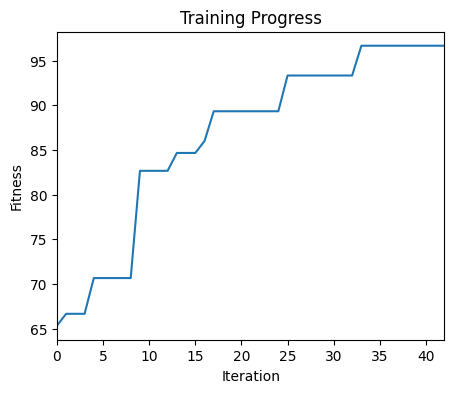

In [ ]:
# Assuming population object is stored in a variable named 'pop'
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.plot(pop.history)
plt.xlabel("Iteration")

plt.ylabel("Fitness")
plt.title("Training Progress")

plt.xlim(0, 42)
plt.show()


In [ ]:

predictions = best_nn.model.predict(X_test)
test_accuracy = np.mean(np.argmax(predictions, axis=1) == y_test)
print(test_accuracy)

1/1 [==============================] - 0s 52ms/step
0.7


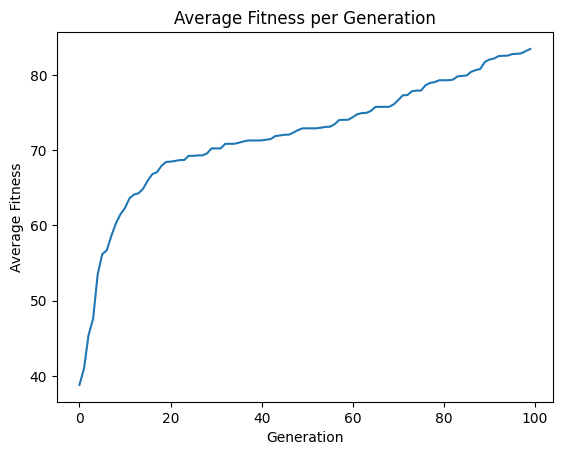

In [ ]:
import matplotlib.pyplot as plt

def plot_average_fitness(average_generation):
  """
  Plots the average fitness for each generation.

  Args:
      fitness_history (list): A list containing the average fitness value for each generation.
  """

  # Generations (x-axis)
  generations = np.arange(len(average_generation))

  # Plot average fitness vs generations
  plt.plot(generations, average_generation)

  # Label axes and title
  plt.xlabel("Generation")
  plt.ylabel("Average Fitness")
  plt.title("Average Fitness per Generation")

  # Show the plot
  plt.show()
plot_average_fitness(pop.average_generation)

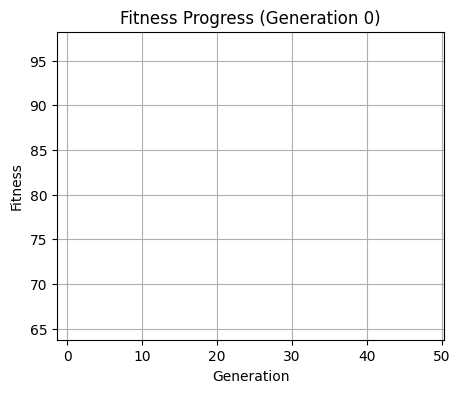

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

generations = range(1, 50)
fitness_values = pop.history

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_xlabel('Generation')
ax.set_ylabel('MAX_Fitness_Per_Generation')
ax.set_title('Max Fitness Progress Across Generations')

# Function to update the plot for each frame
def update_plot(frame):
    ax.clear()
    ax.plot(generations[:frame], fitness_values[:frame], marker='o')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Fitness Progress (Generation {frame})')
    ax.grid(True)

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=len(generations), interval=200, repeat=False)

# Display the animation
HTML(ani.to_jshtml())


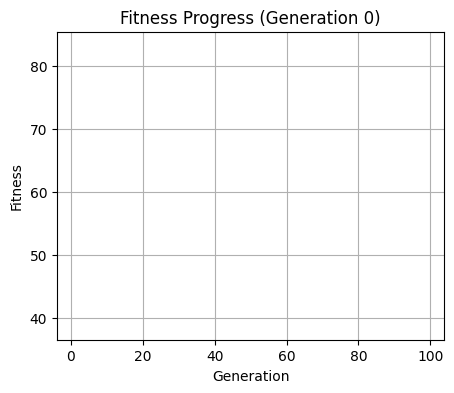

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

generations = range(1, len(pop.average_generation) + 1)
fitness_values = pop.average_generation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_xlabel('Generation')
ax.set_ylabel('Average Fitness per Generation')
ax.set_title('Average Fitness Progress Across Generations')

# Function to update the plot for each frame
def update_plot(frame):
    ax.clear()
    ax.plot(generations[:frame], fitness_values[:frame], marker='o')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Fitness Progress (Generation {frame})')
    ax.grid(True)

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=len(generations), interval=200, repeat=False)

# Display the animation
HTML(ani.to_jshtml())


SAVE
**SAVE**

In [ ]:
# Assuming best individual is at index 0 (modify if different)
best_individual_iris = pop.population[0]
import pickle

# Assuming best_individual holds the best model
with open('best_individual_iris.pkl', 'wb') as f:
  pickle.dump(best_individual_iris, f)


In [ ]:
from google.colab import files

# Download the file
files.download('best_individual_iris.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>